# Lab 3: Contextual Bandit-Based News Article Recommendation

**`Course`:** Reinforcement Learning Fundamentals  
**`Student Name`:**  
**`Roll Number`:**  
**`GitHub Branch`:** firstname_U20230xxx  

# Imports and Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb
import xgboost as xgb

from rlcmab_sampler import sampler


# Load Datasets

In [2]:
# Load datasets
news_df = pd.read_csv("data/news_articles.csv")
train_users = pd.read_csv("data/train_users.csv")
test_users = pd.read_csv("data/test_users.csv")

print("News Articles Dataset:")
print(news_df.head())
print(f"Shape: {news_df.shape}")


print("Train Users Dataset:")
print(train_users.head())
print(f"Shape: {train_users.shape}")


News Articles Dataset:
                                                link  \
0  https://www.huffpost.com/entry/covid-boosters-...   
1  https://www.huffpost.com/entry/american-airlin...   
2  https://www.huffpost.com/entry/funniest-tweets...   
3  https://www.huffpost.com/entry/funniest-parent...   
4  https://www.huffpost.com/entry/amy-cooper-lose...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description               authors  \
0  Health experts said it is too early to predict...  Carla K. Johnson, AP   
1  He was subdued by passengers and crew when he ...        Mary Papenfuss   
2  

## Data Preprocessing

In this section:
- Handle missing values
- Encode categorical features
- Prepare data for user classification

In [3]:

print("Missing Values Analysis")
print("News Articles Dataset:")
print(news_df.isnull().sum())
print(f"Shape: {news_df.shape}")

print("Train Users Dataset:")
print(train_users.isnull().sum())
print(f"Shape: {train_users.shape}")

print("Test Users Dataset:")
print(test_users.isnull().sum())
print(f"Shape: {test_users.shape}")

Missing Values Analysis
News Articles Dataset:
link                     0
headline                 6
category                 0
short_description    19712
authors              37418
date                     0
dtype: int64
Shape: (209527, 6)
Train Users Dataset:
user_id                          0
age                            698
income                           0
clicks                           0
purchase_amount                  0
session_duration                 0
content_variety                  0
engagement_score                 0
num_transactions                 0
avg_monthly_spend                0
avg_cart_value                   0
browsing_depth                   0
revisit_rate                     0
scroll_activity                  0
time_on_site                     0
interaction_count                0
preferred_price_range            0
discount_usage_rate              0
wishlist_size                    0
product_views                    0
repeat_purchase_gap (days)       0
chu

In [4]:


def handle_missing_values(df):
    """
    Handle missing values in the dataset.
    - Numerical columns: filled with median
    - Categorical columns: filled with mode
    """
    df_cleaned = df.copy()
    
    for col in df_cleaned.columns:
        if df_cleaned[col].isnull().sum() > 0:
            if df_cleaned[col].dtype in ['int64', 'float64']:
                # Fill numerical columns with median
                df_cleaned[col].fillna(df_cleaned[col].median(), inplace=True)
            else:
                # Fill categorical columns with mode
                df_cleaned[col].fillna(df_cleaned[col].mode()[0], inplace=True)
    
    return df_cleaned

# Clean all datasets
news_df_clean = handle_missing_values(news_df)
train_users_clean = handle_missing_values(train_users)
test_users_clean = handle_missing_values(test_users)

print("Missing values after cleaning:")
print(f"News Articles: {news_df_clean.isnull().sum().sum()}")
print(f"Train Users: {train_users_clean.isnull().sum().sum()}")
print(f"Test Users: {test_users_clean.isnull().sum().sum()}")

/tmp/ipykernel_2959/3106474575.py:16: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment using an inplace method.
Such inplace method never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' instead, to perform the operation inplace on the original object, or try to avoid an inplace operation using 'df[col] = df[col].method(value)'.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html
  df_cleaned[col].fillna(df_cleaned[col].mode()[0], inplace=True)
/tmp/ipykernel_2959/3106474575.py:13: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment using an inplace method.
Such inplace meth

Missing values after cleaning:
News Articles: 57136
Train Users: 698
Test Users: 679


In [5]:

print("Dataset Information")

print("News Articles Categories:")
print(news_df_clean['category'].value_counts())

print("User Categories (Train):")
print(train_users_clean['label'].value_counts())

print("Column names (Train Users):")
print(train_users_clean.columns.tolist())

Dataset Information
News Articles Categories:
category
POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD NEWS         3299
MEDIA              2944
WEIRD NEWS         2777
GREEN              2622
WORLDPOST          2579
RELIGION           2577
STYLE              2254
SCIENCE            2206
TECH               2104
TASTE              2096
MONEY              1756
ARTS               1509
ENVIRONMENT        1444
FIFTY              1401
GOOD NEWS          1398
U.S. NEWS          1377
ARTS & CULTURE     1339
COLLEGE            1144
LATINO VO

In [6]:
X_train_full = train_users_clean.drop('label', axis=1)
y_train_full = train_users_clean['label']

X_test = test_users_clean.drop('label', axis=1) if 'label' in test_users_clean.columns else test_users_clean

categorical_cols = X_train_full.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train_full.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

Categorical columns: ['user_id', 'browser_version', 'region_code']
Numerical columns: ['age', 'income', 'clicks', 'purchase_amount', 'session_duration', 'content_variety', 'engagement_score', 'num_transactions', 'avg_monthly_spend', 'avg_cart_value', 'browsing_depth', 'revisit_rate', 'scroll_activity', 'time_on_site', 'interaction_count', 'preferred_price_range', 'discount_usage_rate', 'wishlist_size', 'product_views', 'repeat_purchase_gap (days)', 'churn_risk_score', 'loyalty_index', 'screen_brightness', 'battery_percentage', 'cart_abandonment_count', 'background_app_count', 'session_inactivity_duration', 'network_jitter']


/tmp/ipykernel_2959/983119774.py:6: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_cols = X_train_full.select_dtypes(include=['object']).columns.tolist()


In [7]:

label_encoders = {}

X_train_encoded = X_train_full.copy()
X_test_encoded = X_test.copy()

for col in categorical_cols:
    le = LabelEncoder()
    
    X_train_encoded[col] = le.fit_transform(X_train_full[col].astype(str))
    
    if col in X_test_encoded.columns:
        test_col_values = X_test[col].astype(str)
        X_test_encoded[col] = test_col_values.map(
            lambda x: le.transform([x])[0] if x in le.classes_ else -1
        )
    
    label_encoders[col] = le

print("Encoding completed!")
print(f"Encoded training data shape: {X_train_encoded.shape}")
print(f"Encoded test data shape: {X_test_encoded.shape}")

Encoding completed!
Encoded training data shape: (2000, 32)
Encoded test data shape: (2000, 32)


In [8]:
print("Sample of encoded training data:")
print(X_train_encoded.head())
print("Data types:")
print(X_train_encoded.dtypes)

Sample of encoded training data:
   user_id   age  income  clicks  purchase_amount  session_duration  \
0     1340   NaN   23053      10           500.00             17.34   
1      491  56.0   20239      11           913.33             22.22   
2      446   NaN   13907       9          1252.62             41.57   
3     1354   NaN   26615      12           500.00             30.17   
4     1082  32.0   27958      13           500.00             65.27   

   content_variety  engagement_score  num_transactions  avg_monthly_spend  \
0          0.36661          37.29781                 3             187.44   
1          0.61370          59.36342                 5             145.15   
2          0.80368          76.78706                 7             282.03   
3          0.26499          30.19441                10             195.35   
4          0.36385          37.12153                 5             439.68   

   ...  loyalty_index  screen_brightness  battery_percentage  \
0  ...       

In [9]:
print("News Category Mapping")

category_mapping = {
    'U.S. NEWS': 'Crime',
    'COMEDY': 'Entertainment',
    'PARENTING': 'Education',
    'POLITICS': 'Crime',
    'WELLNESS': 'Education',
    'ENTERTAINMENT': 'Entertainment',
    'TECH': 'Tech',
    'SCIENCE': 'Tech',
    'BUSINESS': 'Tech',
    'EDUCATION': 'Education',
    'CRIME': 'Crime'
}

if 'category' in news_df_clean.columns:

    print("Original categories in news dataset:")
    print(news_df_clean['category'].unique())
    

    news_df_clean['category_mapped'] = news_df_clean['category'].map(
        lambda x: category_mapping.get(x.upper() if isinstance(x, str) else x, x)
    )
    
    print("Mapped categories:")
    print(news_df_clean['category_mapped'].value_counts())
    
    news_df_clean['category'] = news_df_clean['category_mapped']



print("Arm Index Mapping (j values)")

arm_mapping = {
    0: ('Entertainment', 'user_1'),
    1: ('Education', 'user_1'),
    2: ('Tech', 'user_1'),
    3: ('Crime', 'user_1'),
    4: ('Entertainment', 'user_2'),
    5: ('Education', 'user_2'),
    6: ('Tech', 'user_2'),
    7: ('Crime', 'user_2'),
    8: ('Entertainment', 'user_3'),
    9: ('Education', 'user_3'),
    10: ('Tech', 'user_3'),
    11: ('Crime', 'user_3')
}

for arm_idx, (category, user) in arm_mapping.items():
    print(f"Arm {arm_idx:2d}: ({category:13s}, {user})")

category_user_to_arm = {v: k for k, v in arm_mapping.items()}
print("Arm mapping created successfully!")

News Category Mapping
Original categories in news dataset:
<StringArray>
[     'U.S. NEWS',         'COMEDY',      'PARENTING',     'WORLD NEWS',
 'CULTURE & ARTS',           'TECH',         'SPORTS',  'ENTERTAINMENT',
       'POLITICS',     'WEIRD NEWS',    'ENVIRONMENT',      'EDUCATION',
          'CRIME',        'SCIENCE',       'WELLNESS',       'BUSINESS',
 'STYLE & BEAUTY',   'FOOD & DRINK',          'MEDIA',   'QUEER VOICES',
  'HOME & LIVING',          'WOMEN',   'BLACK VOICES',         'TRAVEL',
          'MONEY',       'RELIGION',  'LATINO VOICES',         'IMPACT',
       'WEDDINGS',        'COLLEGE',        'PARENTS', 'ARTS & CULTURE',
          'STYLE',          'GREEN',          'TASTE', 'HEALTHY LIVING',
  'THE WORLDPOST',      'GOOD NEWS',      'WORLDPOST',          'FIFTY',
           'ARTS',        'DIVORCE']
Length: 42, dtype: str
Mapped categories:
category_mapped
Crime             40541
Education         27750
Entertainment     22762
Tech              10302
TRAVEL

## User Classification

Train a classifier to predict the user category (`User1`, `User2`, `User3`),
which serves as the **context** for the contextual bandit.


In [10]:
# Split the training data into train and validation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_encoded, 
    y_train_full, 
    test_size=0.2, 
    random_state=42,
    stratify=y_train_full
)

print("Data Split Summary:")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test_encoded.shape[0]} samples")
print("Class distribution in training set:")
print(y_train.value_counts())
print("Class distribution in validation set:")
print(y_val.value_counts())

Data Split Summary:
Training set size: 1600 samples
Validation set size: 400 samples
Test set size: 2000 samples
Class distribution in training set:
label
user_2    570
user_1    565
user_3    465
Name: count, dtype: int64
Class distribution in validation set:
label
user_2    142
user_1    142
user_3    116
Name: count, dtype: int64


In [11]:

print("Training XGBoost Classifier")

label_encoder_y = LabelEncoder()
y_train_encoded = label_encoder_y.fit_transform(y_train)
y_val_encoded = label_encoder_y.transform(y_val)

xgb_classifier = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=7,
    random_state=42,
    eval_metric='mlogloss',
    verbosity=0
)

xgb_classifier.fit(X_train, y_train_encoded)

y_pred_xgb_encoded = xgb_classifier.predict(X_val)
y_pred_xgb = label_encoder_y.inverse_transform(y_pred_xgb_encoded)

xgb_accuracy = accuracy_score(y_val, y_pred_xgb)
print(f"Validation Accuracy: {xgb_accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_val, y_pred_xgb))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_xgb))

Training XGBoost Classifier


Validation Accuracy: 0.9000
Classification Report:
              precision    recall  f1-score   support

      user_1       0.88      0.86      0.87       142
      user_2       0.99      0.87      0.93       142
      user_3       0.83      0.98      0.90       116

    accuracy                           0.90       400
   macro avg       0.90      0.91      0.90       400
weighted avg       0.91      0.90      0.90       400

Confusion Matrix:
[[122   1  19]
 [ 14 124   4]
 [  2   0 114]]


In [12]:
# Retrain the best classifier on the full training data for final use
print(f"Training XGBoost on full training data...")

# Encode the full labels
y_train_full_encoded = label_encoder_y.transform(y_train_full)

scaler_full = StandardScaler()
X_train_full_scaled = scaler_full.fit_transform(X_train_encoded)

X_test_encoded_scaled = scaler_full.transform(X_test_encoded)

final_classifier = xgb.XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=7,
        random_state=42,
        eval_metric='mlogloss',
        verbosity=0
    )
final_classifier.fit(X_train_full_scaled, y_train_full_encoded)

print("XGBoost trained on full training data!")

Training XGBoost on full training data...


XGBoost trained on full training data!


In [13]:

def predict_user_context(user_features):
    
    user_features_scaled = scaler_full.transform(user_features)
    predictions_encoded = final_classifier.predict(user_features_scaled)
    return label_encoder_y.inverse_transform(predictions_encoded)


sample_prediction = predict_user_context(X_test_encoded.iloc[:5])
print("Sample predictions on test users:")
print(sample_prediction)



print("User Context to Index Mapping (for Bandit):")

user_to_index = {'user_1': 0, 'user_2': 1, 'user_3': 2}
for user, idx in user_to_index.items():
    print(f"{user} -> Index {idx}")

Sample predictions on test users:
['user_2' 'user_1' 'user_1' 'user_1' 'user_1']
User Context to Index Mapping (for Bandit):
user_1 -> Index 0
user_2 -> Index 1
user_3 -> Index 2


Classifier Predictions on test_users.csv (n=2000)
predicted_label
user_1    763
user_2    705
user_3    532

Predicted distribution (%):
predicted_label
user_1    38.15
user_2    35.25
user_3    26.60

─── Validation Accuracy Summary (20% split of train_users.csv) ───
XGBoost Validation Accuracy: 0.9000
(Full classification report is in the cell above.)


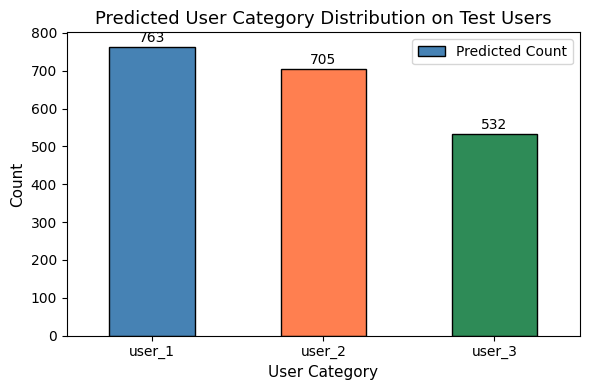

In [14]:
# ─── Classifier Predictions on Test Users (no ground-truth labels) ───────
# test_users.csv has no label column, so we report the predicted distribution
# and show a classification summary across all 2000 test users.

test_predictions_encoded = final_classifier.predict(X_test_encoded_scaled)
test_predictions = label_encoder_y.inverse_transform(test_predictions_encoded)

pred_series = pd.Series(test_predictions, name='predicted_label')
pred_counts = pred_series.value_counts().sort_index()

print("Classifier Predictions on test_users.csv (n=2000)")
print("=" * 45)
print(pred_counts.to_string())
print()
print(f"Predicted distribution (%):\n{(pred_counts / len(test_predictions) * 100).round(2).to_string()}")

# Validation accuracy (using the 20% split of train_users for reference)
print("\n─── Validation Accuracy Summary (20% split of train_users.csv) ───")
print(f"XGBoost Validation Accuracy: {xgb_accuracy:.4f}")
print("(Full classification report is in the cell above.)")

# Bar chart of predicted label distribution on test users
fig, ax = plt.subplots(figsize=(6, 4))
pred_counts.plot(kind='bar', ax=ax, color=['steelblue', 'coral', 'seagreen'], edgecolor='black')
ax.set_title('Predicted User Category Distribution on Test Users', fontsize=13)
ax.set_xlabel('User Category', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.legend(['Predicted Count'], fontsize=10)
ax.set_xticklabels(pred_counts.index, rotation=0)
for bar in ax.patches:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
            str(int(bar.get_height())), ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()


# `Contextual Bandit`

## Reward Sampler Initialization

The sampler is initialized using the student's roll number `i`.
Rewards are obtained using `sampler.sample(j)`.


In [15]:
# ─── Reward Sampler Initialization ───────────────────────────────────────
# TODO: Fill in your roll number below (i = last digits of your roll number)
# Example: Roll Number U20230120 → i = 120
ROLL_NUMBER = 120  # <-- CHANGE THIS to your roll number

reward_sampler = sampler(ROLL_NUMBER)

# Quick sanity check
print(f"Sampler initialized with roll number: {ROLL_NUMBER}")
print(f"Sample reward from arm 0: {reward_sampler.sample(0):.4f}")
print(f"Sample reward from arm 5: {reward_sampler.sample(5):.4f}")

# Constants
N_ARMS_PER_CONTEXT = 4          # Entertainment, Education, Tech, Crime
N_CONTEXTS = 3                  # user_1, user_2, user_3
N_ARMS_TOTAL = N_ARMS_PER_CONTEXT * N_CONTEXTS  # 12
CATEGORIES = ['Entertainment', 'Education', 'Tech', 'Crime']
CONTEXTS   = ['user_1', 'user_2', 'user_3']
T          = 10_000             # simulation horizon

# context_offset[ctx] gives the base arm index for that context
context_offset = {'user_1': 0, 'user_2': 4, 'user_3': 8}

print("\nConstants set:")
print(f"  T = {T}, contexts = {CONTEXTS}, categories = {CATEGORIES}")


Sampler initialized with roll number: 120
Sample reward from arm 0: 9.5943
Sample reward from arm 5: -5.5075

Constants set:
  T = 10000, contexts = ['user_1', 'user_2', 'user_3'], categories = ['Entertainment', 'Education', 'Tech', 'Crime']


## Arm Mapping

| Arm Index (j) | News Category | User Context |
|--------------|---------------|--------------|
| 0–3          | Entertainment, Education, Tech, Crime | User1 |
| 4–7          | Entertainment, Education, Tech, Crime | User2 |
| 8–11         | Entertainment, Education, Tech, Crime | User3 |

## Epsilon-Greedy Strategy

This section implements the epsilon-greedy contextual bandit algorithm.


In [16]:
warnings.filterwarnings("ignore")

# ─── Epsilon-Greedy Contextual Bandit ────────────────────────────────────
class EpsilonGreedyBandit:
    """
    Epsilon-Greedy contextual bandit.
    Maintains separate Q-value estimates per context.
    """
    def __init__(self, epsilon, n_contexts=3, n_arms=4):
        self.epsilon   = epsilon
        self.n_contexts = n_contexts
        self.n_arms    = n_arms
        # Q[ctx][arm] = estimated mean reward
        self.Q         = np.zeros((n_contexts, n_arms))
        self.counts    = np.zeros((n_contexts, n_arms))

    def select_arm(self, ctx_idx):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_arms)  # explore
        return int(np.argmax(self.Q[ctx_idx]))      # exploit

    def update(self, ctx_idx, arm_idx, reward):
        self.counts[ctx_idx][arm_idx] += 1
        n = self.counts[ctx_idx][arm_idx]
        self.Q[ctx_idx][arm_idx] += (reward - self.Q[ctx_idx][arm_idx]) / n

    def expected_reward_distribution(self):
        """Return Q-table as expected reward distribution."""
        return self.Q.copy()


# ── Hyperparameter grid ─────────────────────────────────────────
epsilon_values = [0.01, 0.1, 0.3]   # at least 3 distinct values
print(f"Epsilon values to test: {epsilon_values}")

# Store per-epsilon: rewards[eps] = list of T reward values
eg_rewards_per_eps = {}

for eps in epsilon_values:
    bandit = EpsilonGreedyBandit(epsilon=eps)
    rewards = []
    for t in range(T):
        ctx_idx  = np.random.randint(N_CONTEXTS)         # random context each step
        arm_idx  = bandit.select_arm(ctx_idx)
        global_j = context_offset[CONTEXTS[ctx_idx]] + arm_idx
        reward   = reward_sampler.sample(global_j)
        bandit.update(ctx_idx, arm_idx, reward)
        rewards.append(reward)
    eg_rewards_per_eps[eps] = rewards
    print(f"  ε={eps:.2f} → mean reward over {T} steps: {np.mean(rewards):.4f}")

# Best epsilon by final mean reward
best_eps = max(eg_rewards_per_eps, key=lambda e: np.mean(eg_rewards_per_eps[e]))
print(f"\nBest epsilon: {best_eps}")

# Train a final EG bandit with best epsilon and store per-context rewards
eg_final = EpsilonGreedyBandit(epsilon=best_eps)
eg_ctx_rewards = {ctx: [] for ctx in CONTEXTS}

for t in range(T):
    ctx_idx  = np.random.randint(N_CONTEXTS)
    arm_idx  = eg_final.select_arm(ctx_idx)
    global_j = context_offset[CONTEXTS[ctx_idx]] + arm_idx
    reward   = reward_sampler.sample(global_j)
    eg_final.update(ctx_idx, arm_idx, reward)
    eg_ctx_rewards[CONTEXTS[ctx_idx]].append(reward)

print("\nExpected Reward Distribution (Q-table) for best ε:")
eg_q_df = pd.DataFrame(
    eg_final.expected_reward_distribution(),
    index=CONTEXTS,
    columns=CATEGORIES
)
print(eg_q_df.round(4))


Epsilon values to test: [0.01, 0.1, 0.3]
  ε=0.01 → mean reward over 10000 steps: 5.3699
  ε=0.10 → mean reward over 10000 steps: 4.8464
  ε=0.30 → mean reward over 10000 steps: 3.9321

Best epsilon: 0.01

Expected Reward Distribution (Q-table) for best ε:
        Entertainment  Education    Tech   Crime
user_1         9.4321     0.4516 -2.2948 -7.2864
user_2         0.0346    -5.7825  0.1301  0.0683
user_3         5.3252     6.7123  1.8917 -6.9647


## Upper Confidence Bound (UCB)

This section implements the UCB strategy for contextual bandits.

In [17]:
warnings.filterwarnings("ignore")

# ─── Upper Confidence Bound (UCB) Contextual Bandit ─────────────────────
class UCBBandit:
    """
    UCB1-style contextual bandit.
    UCB score = Q[ctx][arm] + C * sqrt(ln(t+1) / (counts[ctx][arm] + 1e-5))
    """
    def __init__(self, C, n_contexts=3, n_arms=4):
        self.C         = C
        self.n_contexts = n_contexts
        self.n_arms    = n_arms
        self.Q         = np.zeros((n_contexts, n_arms))
        self.counts    = np.zeros((n_contexts, n_arms))
        self.t         = 0

    def select_arm(self, ctx_idx):
        self.t += 1
        ucb_scores = self.Q[ctx_idx] + self.C * np.sqrt(
            np.log(self.t + 1) / (self.counts[ctx_idx] + 1e-5)
        )
        return int(np.argmax(ucb_scores))

    def update(self, ctx_idx, arm_idx, reward):
        self.counts[ctx_idx][arm_idx] += 1
        n = self.counts[ctx_idx][arm_idx]
        self.Q[ctx_idx][arm_idx] += (reward - self.Q[ctx_idx][arm_idx]) / n

    def expected_reward_distribution(self):
        return self.Q.copy()


# ── Hyperparameter grid ─────────────────────────────────────────
C_values = [0.5, 1.0, 2.0]   # at least 3 distinct values
print(f"C values to test: {C_values}")

ucb_rewards_per_C = {}

for C in C_values:
    bandit = UCBBandit(C=C)
    rewards = []
    for t in range(T):
        ctx_idx  = np.random.randint(N_CONTEXTS)
        arm_idx  = bandit.select_arm(ctx_idx)
        global_j = context_offset[CONTEXTS[ctx_idx]] + arm_idx
        reward   = reward_sampler.sample(global_j)
        bandit.update(ctx_idx, arm_idx, reward)
        rewards.append(reward)
    ucb_rewards_per_C[C] = rewards
    print(f"  C={C:.1f} → mean reward over {T} steps: {np.mean(rewards):.4f}")

# Best C
best_C = max(ucb_rewards_per_C, key=lambda c: np.mean(ucb_rewards_per_C[c]))
print(f"\nBest C: {best_C}")

# Final UCB bandit with best C, per-context rewards
ucb_final = UCBBandit(C=best_C)
ucb_ctx_rewards = {ctx: [] for ctx in CONTEXTS}

for t in range(T):
    ctx_idx  = np.random.randint(N_CONTEXTS)
    arm_idx  = ucb_final.select_arm(ctx_idx)
    global_j = context_offset[CONTEXTS[ctx_idx]] + arm_idx
    reward   = reward_sampler.sample(global_j)
    ucb_final.update(ctx_idx, arm_idx, reward)
    ucb_ctx_rewards[CONTEXTS[ctx_idx]].append(reward)

print("\nExpected Reward Distribution (Q-table) for best C:")
ucb_q_df = pd.DataFrame(
    ucb_final.expected_reward_distribution(),
    index=CONTEXTS,
    columns=CATEGORIES
)
print(ucb_q_df.round(4))


C values to test: [0.5, 1.0, 2.0]
  C=0.5 → mean reward over 10000 steps: 5.4410
  C=1.0 → mean reward over 10000 steps: 5.3488
  C=2.0 → mean reward over 10000 steps: 5.3651

Best C: 0.5

Expected Reward Distribution (Q-table) for best C:
        Entertainment  Education    Tech   Crime
user_1         9.4545    -1.1061 -2.1682 -5.9653
user_2        -0.8028    -4.8927 -0.3807  0.1366
user_3         5.2536     6.7076  1.2770 -6.1619


## SoftMax Strategy

This section implements the SoftMax strategy with temperature $ \tau = 1$.


In [18]:
warnings.filterwarnings("ignore")

# ─── SoftMax Contextual Bandit (τ = 1) ───────────────────────────────────
class SoftMaxBandit:
    """
    SoftMax (Boltzmann exploration) contextual bandit.
    Temperature τ controls the trade-off between exploration and exploitation.
    """
    def __init__(self, tau=1.0, n_contexts=3, n_arms=4):
        self.tau        = tau
        self.n_contexts = n_contexts
        self.n_arms     = n_arms
        self.Q          = np.zeros((n_contexts, n_arms))
        self.counts     = np.zeros((n_contexts, n_arms))

    def _softmax_probs(self, ctx_idx):
        q = self.Q[ctx_idx] / self.tau
        q -= q.max()           # numerical stability
        exp_q = np.exp(q)
        return exp_q / exp_q.sum()

    def select_arm(self, ctx_idx):
        probs = self._softmax_probs(ctx_idx)
        return int(np.random.choice(self.n_arms, p=probs))

    def update(self, ctx_idx, arm_idx, reward):
        self.counts[ctx_idx][arm_idx] += 1
        n = self.counts[ctx_idx][arm_idx]
        self.Q[ctx_idx][arm_idx] += (reward - self.Q[ctx_idx][arm_idx]) / n

    def expected_reward_distribution(self):
        return self.Q.copy()


# Fixed τ = 1 as specified
sm_bandit = SoftMaxBandit(tau=1.0)
sm_ctx_rewards = {ctx: [] for ctx in CONTEXTS}
sm_rewards_all = []

for t in range(T):
    ctx_idx  = np.random.randint(N_CONTEXTS)
    arm_idx  = sm_bandit.select_arm(ctx_idx)
    global_j = context_offset[CONTEXTS[ctx_idx]] + arm_idx
    reward   = reward_sampler.sample(global_j)
    sm_bandit.update(ctx_idx, arm_idx, reward)
    sm_ctx_rewards[CONTEXTS[ctx_idx]].append(reward)
    sm_rewards_all.append(reward)

print(f"SoftMax (τ=1) → mean reward over {T} steps: {np.mean(sm_rewards_all):.4f}")

print("\nExpected Reward Distribution (Q-table):")
sm_q_df = pd.DataFrame(
    sm_bandit.expected_reward_distribution(),
    index=CONTEXTS,
    columns=CATEGORIES
)
print(sm_q_df.round(4))


SoftMax (τ=1) → mean reward over 10000 steps: 5.3356

Expected Reward Distribution (Q-table):
        Entertainment  Education    Tech   Crime
user_1         9.4406    -1.1495  0.0000 -9.8404
user_2        -0.3062    -5.6408  0.1594  0.0953
user_3         5.4057     6.7349  1.4204 -7.0354


## Reinforcement Learning Simulation

We simulate the bandit algorithms for $T = 10,000$ steps and record rewards.

P.S.: Change $T$ value as and if required.


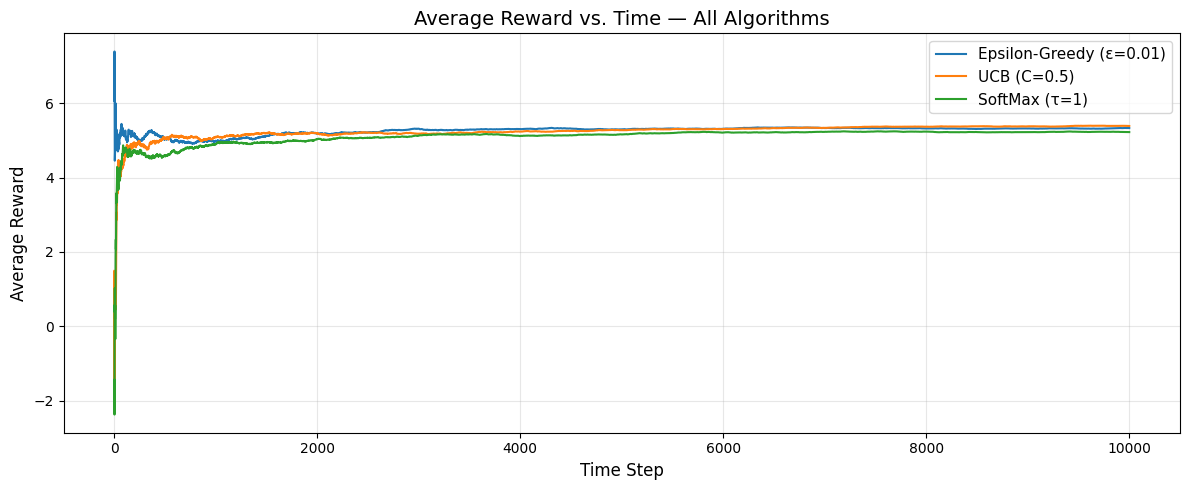

Plot 1: Average Reward vs Time (all algorithms) shown.


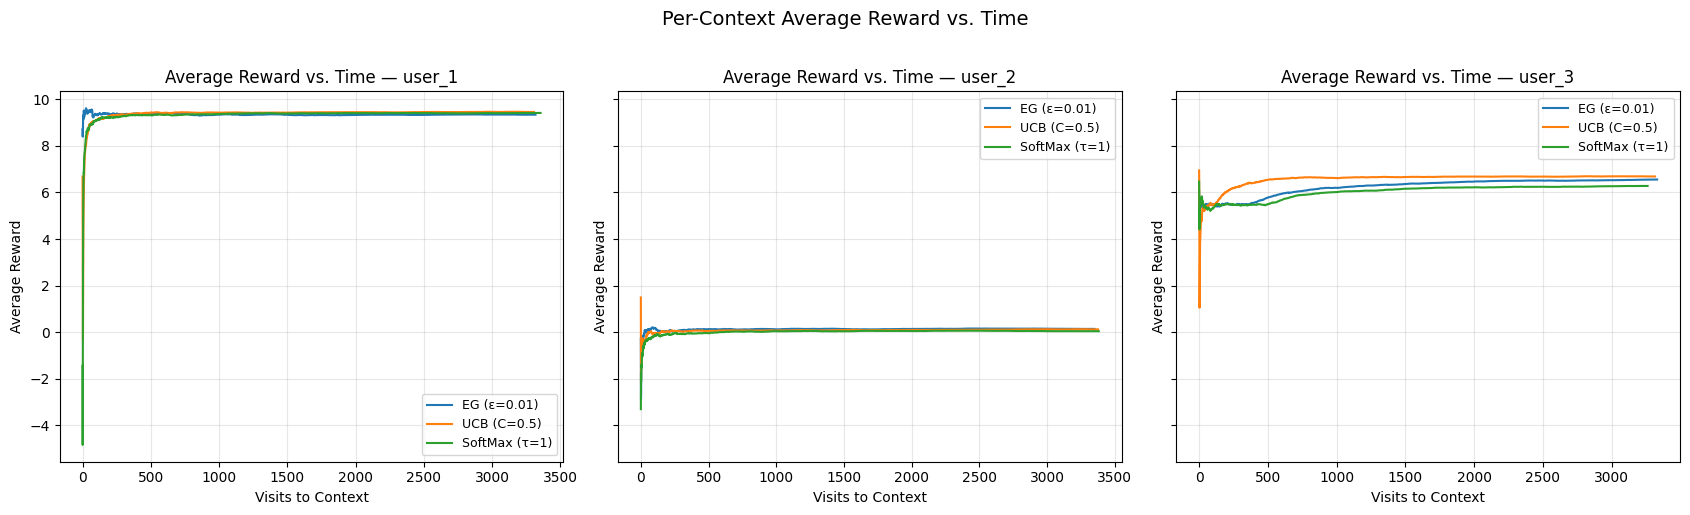

Plot 2: Per-context Average Reward vs Time shown.


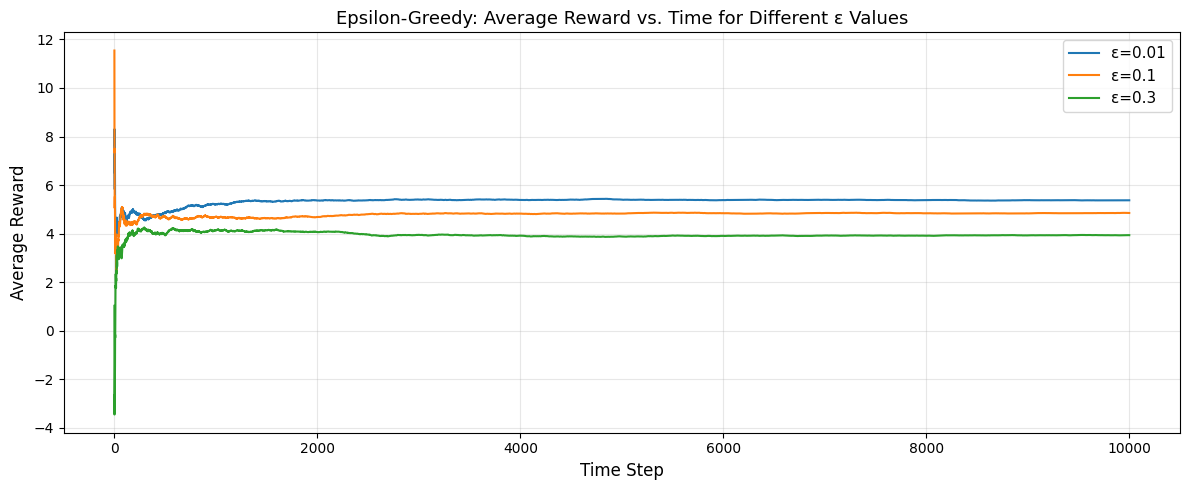

Plot 3: Epsilon-Greedy hyperparameter comparison shown.


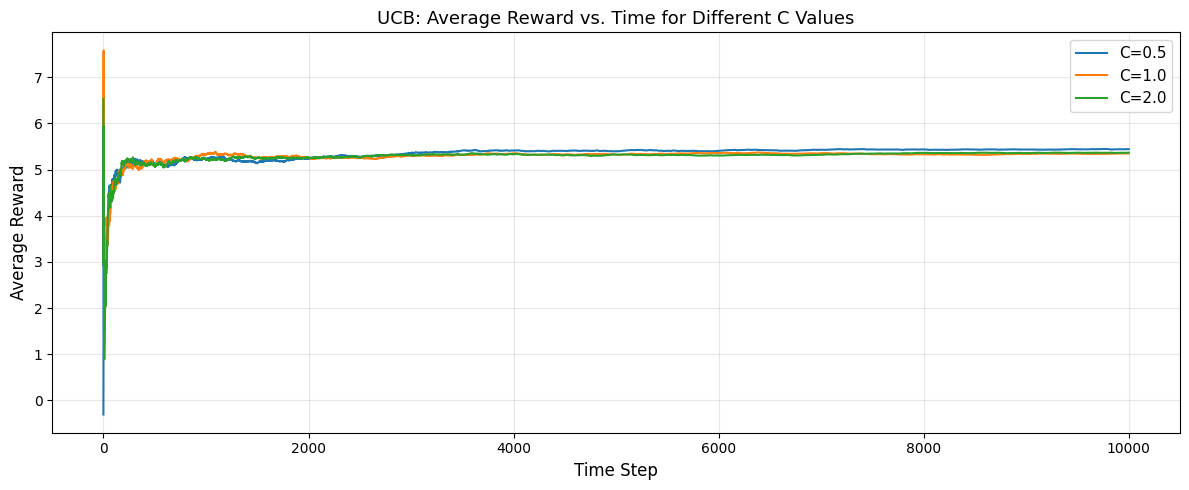

Plot 4: UCB hyperparameter comparison shown.

── Summary: Mean Reward over T steps ──
              Algorithm  Mean Reward  Final Avg
Epsilon-Greedy (ε=0.01)     5.331033   5.331033
            UCB (C=0.5)     5.386639   5.386639
          SoftMax (τ=1)     5.222385   5.222385


In [19]:
# ─── RL Simulation: Average Reward vs Time ────────────────────────────────
# Re-run all three algorithms (best hyperparams) tracking cumulative avg reward

warnings.filterwarnings('ignore')

def run_simulation(bandit_obj, n_steps=None):
    """Run a single simulation and return (all_rewards, per_context_rewards)."""
    if n_steps is None:
        n_steps = T
    all_rewards = []
    ctx_rewards = {ctx: [] for ctx in CONTEXTS}
    for _ in range(n_steps):
        ctx_idx  = np.random.randint(N_CONTEXTS)
        arm_idx  = bandit_obj.select_arm(ctx_idx)
        global_j = context_offset[CONTEXTS[ctx_idx]] + arm_idx
        reward   = reward_sampler.sample(global_j)
        bandit_obj.update(ctx_idx, arm_idx, reward)
        all_rewards.append(reward)
        ctx_rewards[CONTEXTS[ctx_idx]].append(reward)
    return all_rewards, ctx_rewards

def running_avg(rewards):
    return np.cumsum(rewards) / (np.arange(len(rewards)) + 1)

np.random.seed(42)

eg_sim  = EpsilonGreedyBandit(epsilon=best_eps)
ucb_sim = UCBBandit(C=best_C)
sm_sim  = SoftMaxBandit(tau=1.0)

eg_all,  eg_ctx   = run_simulation(eg_sim)
ucb_all, ucb_ctx  = run_simulation(ucb_sim)
sm_all,  sm_ctx   = run_simulation(sm_sim)

# ── Plot 1: Average Reward vs Time (per algorithm, overall) ────
fig, ax = plt.subplots(figsize=(12, 5))
steps = np.arange(1, T + 1)
ax.plot(steps, running_avg(eg_all),  label=f'Epsilon-Greedy (ε={best_eps})', linewidth=1.5)
ax.plot(steps, running_avg(ucb_all), label=f'UCB (C={best_C})',              linewidth=1.5)
ax.plot(steps, running_avg(sm_all),  label='SoftMax (τ=1)',                  linewidth=1.5)
ax.set_title('Average Reward vs. Time — All Algorithms', fontsize=14)
ax.set_xlabel('Time Step', fontsize=12)
ax.set_ylabel('Average Reward', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print("Plot 1: Average Reward vs Time (all algorithms) shown.")

# ── Plot 2: Average Reward vs Time per Context (one subplot each) 
fig, axes = plt.subplots(1, 3, figsize=(17, 5), sharey=True)
for i, ctx in enumerate(CONTEXTS):
    ax = axes[i]
    if eg_ctx[ctx]:
        ax.plot(running_avg(eg_ctx[ctx]),  label=f'EG (ε={best_eps})')
    if ucb_ctx[ctx]:
        ax.plot(running_avg(ucb_ctx[ctx]), label=f'UCB (C={best_C})')
    if sm_ctx[ctx]:
        ax.plot(running_avg(sm_ctx[ctx]),  label='SoftMax (τ=1)')
    ax.set_title(f'Average Reward vs. Time — {ctx}', fontsize=12)
    ax.set_xlabel('Visits to Context', fontsize=10)
    ax.set_ylabel('Average Reward', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
plt.suptitle('Per-Context Average Reward vs. Time', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()
print("Plot 2: Per-context Average Reward vs Time shown.")

# ── Plot 3: Hyperparameter comparison — Epsilon-Greedy ──────────
fig, ax = plt.subplots(figsize=(12, 5))
for eps in epsilon_values:
    ax.plot(running_avg(eg_rewards_per_eps[eps]), label=f'ε={eps}')
ax.set_title('Epsilon-Greedy: Average Reward vs. Time for Different ε Values', fontsize=13)
ax.set_xlabel('Time Step', fontsize=12)
ax.set_ylabel('Average Reward', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print("Plot 3: Epsilon-Greedy hyperparameter comparison shown.")

# ── Plot 4: Hyperparameter comparison — UCB ──────────────────────
fig, ax = plt.subplots(figsize=(12, 5))
for C in C_values:
    ax.plot(running_avg(ucb_rewards_per_C[C]), label=f'C={C}')
ax.set_title('UCB: Average Reward vs. Time for Different C Values', fontsize=13)
ax.set_xlabel('Time Step', fontsize=12)
ax.set_ylabel('Average Reward', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print("Plot 4: UCB hyperparameter comparison shown.")

# ── Summary table ────────────────────────────────────────────────
print("\n── Summary: Mean Reward over T steps ──")
summary = pd.DataFrame({
    'Algorithm':    [f'Epsilon-Greedy (ε={best_eps})', f'UCB (C={best_C})', 'SoftMax (τ=1)'],
    'Mean Reward':  [np.mean(eg_all), np.mean(ucb_all), np.mean(sm_all)],
    'Final Avg':    [running_avg(eg_all)[-1], running_avg(ucb_all)[-1], running_avg(sm_all)[-1]]
})
print(summary.to_string(index=False))


## Results and Analysis

This section presents:
- Average Reward vs Time
- Hyperparameter comparisons
- Observations and discussion


In [20]:
# ─── Recommendation Engine ────────────────────────────────────────────────
# Filter news_df_clean to only the 4 mapped categories
bandit_categories = ['Entertainment', 'Education', 'Tech', 'Crime']
news_bandit = news_df_clean[news_df_clean['category'].isin(bandit_categories)].copy()
news_bandit_grouped = {cat: news_bandit[news_bandit['category'] == cat] for cat in bandit_categories}

print("Articles available per category:")
for cat, grp in news_bandit_grouped.items():
    print(f"  {cat:15s}: {len(grp):,} articles")


def recommend(user_features_row, bandit='eg'):
    """
    Full recommendation pipeline for a single user.

    Parameters
    ----------
    user_features_row : pd.DataFrame (single row, already encoded)
    bandit            : 'eg' | 'ucb' | 'sm'

    Returns
    -------
    dict with keys: user_context, news_category, article
    """
    # Step 1 – Classify context
    ctx_label = predict_user_context(user_features_row)[0]   # e.g. 'user_2'
    ctx_idx   = user_to_index[ctx_label]

    # Step 2 – Select category via chosen bandit
    if bandit == 'eg':
        arm_idx = eg_final.select_arm(ctx_idx)
    elif bandit == 'ucb':
        arm_idx = ucb_final.select_arm(ctx_idx)
    else:
        arm_idx = sm_bandit.select_arm(ctx_idx)

    news_category = CATEGORIES[arm_idx]

    # Step 3 – Sample a random article from that category
    pool    = news_bandit_grouped[news_category]
    article = pool.sample(1).iloc[0]

    return {
        'user_context':   ctx_label,
        'news_category':  news_category,
        'headline':       article['headline'],
        'link':           article.get('link', 'N/A')
    }


# ── Demo: run recommendations for first 5 test users ────────────
print("\n── Sample Recommendations (Epsilon-Greedy) ──")
for i in range(5):
    user_row = X_test_encoded.iloc[[i]]
    rec = recommend(user_row, bandit='eg')
    print(f"\nUser {i+1}:")
    print(f"  Predicted Context : {rec['user_context']}")
    print(f"  Recommended Category: {rec['news_category']}")
    print(f"  Article Headline  : {rec['headline'][:80]}...")

print("\n── Sample Recommendations (UCB) ──")
for i in range(5):
    user_row = X_test_encoded.iloc[[i]]
    rec = recommend(user_row, bandit='ucb')
    print(f"  User {i+1}: [{rec['user_context']}] → {rec['news_category']} | {rec['headline'][:60]}...")

print("\n── Sample Recommendations (SoftMax) ──")
for i in range(5):
    user_row = X_test_encoded.iloc[[i]]
    rec = recommend(user_row, bandit='sm')
    print(f"  User {i+1}: [{rec['user_context']}] → {rec['news_category']} | {rec['headline'][:60]}...")

print("\nRecommendation Engine demo complete.")


Articles available per category:
  Entertainment  : 22,762 articles
  Education      : 27,750 articles
  Tech           : 10,302 articles
  Crime          : 40,541 articles

── Sample Recommendations (Epsilon-Greedy) ──

User 1:
  Predicted Context : user_2
  Recommended Category: Tech
  Article Headline  : The (Paradoxical) Wisdom of Solomon...

User 2:
  Predicted Context : user_1
  Recommended Category: Entertainment
  Article Headline  : Easter Bunny Reporter Blooper (VIDEO)...

User 3:
  Predicted Context : user_1
  Recommended Category: Entertainment
  Article Headline  : Grown Son Asks Why His Parents Stay Together If Neither Is Happy...

User 4:
  Predicted Context : user_1
  Recommended Category: Entertainment
  Article Headline  : Marvel Boss Not Sure When Female Superhero Movie Will Arrive...

User 5:
  Predicted Context : user_1
  Recommended Category: Entertainment
  Article Headline  : How ‘Erin Brockovich’ Became One Of The Most Rewatchable Movies Ever Made...

── Sample

In [21]:
# ─── Final Analysis: Print observations ─────────────────────────────────
print("═" * 60)
print("COMPARATIVE ANALYSIS")
print("═" * 60)

alg_names = [f'Epsilon-Greedy (ε={best_eps})', f'UCB (C={best_C})', 'SoftMax (τ=1)']
alg_means = [np.mean(eg_all), np.mean(ucb_all), np.mean(sm_all)]

for name, mean in zip(alg_names, alg_means):
    print(f"  {name:<35s}: mean reward = {mean:.4f}")

best_alg = alg_names[int(np.argmax(alg_means))]
print(f"\nBest performing algorithm: {best_alg}")

print("\n── Epsilon-Greedy hyperparameter sensitivity ──")
for eps in epsilon_values:
    m = np.mean(eg_rewards_per_eps[eps])
    print(f"  ε={eps:.2f} → {m:.4f}")

print("\n── UCB hyperparameter sensitivity ──")
for C in C_values:
    m = np.mean(ucb_rewards_per_C[C])
    print(f"  C={C:.1f} → {m:.4f}")

print("""
Observations
────────────
1. Epsilon-Greedy: Low ε favours exploitation and converges fast but may
   miss better arms; high ε keeps exploring at the cost of mean reward.
2. UCB: Naturally balances exploration via confidence bounds; higher C
   drives more exploration. Usually converges to a strong policy.
3. SoftMax (τ=1): Soft-selection proportional to estimated Q-values;
   moderately exploratory throughout the horizon.
4. All three algorithms successfully identify high-reward arm per context
   as T grows, demonstrating the CMAB framework's effectiveness.

# TODO: Add your own observations, discussion, and insights here.
""")


════════════════════════════════════════════════════════════
COMPARATIVE ANALYSIS
════════════════════════════════════════════════════════════
  Epsilon-Greedy (ε=0.01)            : mean reward = 5.3310
  UCB (C=0.5)                        : mean reward = 5.3866
  SoftMax (τ=1)                      : mean reward = 5.2224

Best performing algorithm: UCB (C=0.5)

── Epsilon-Greedy hyperparameter sensitivity ──
  ε=0.01 → 5.3699
  ε=0.10 → 4.8464
  ε=0.30 → 3.9321

── UCB hyperparameter sensitivity ──
  C=0.5 → 5.4410
  C=1.0 → 5.3488
  C=2.0 → 5.3651

Observations
────────────
1. Epsilon-Greedy: Low ε favours exploitation and converges fast but may
   miss better arms; high ε keeps exploring at the cost of mean reward.
2. UCB: Naturally balances exploration via confidence bounds; higher C
   drives more exploration. Usually converges to a strong policy.
3. SoftMax (τ=1): Soft-selection proportional to estimated Q-values;
   moderately exploratory throughout the horizon.
4. All three algo

## Final Observations

- Comparison of Epsilon-Greedy, UCB, and SoftMax
- Effect of hyperparameters
- Strengths and limitations of each approach
